# Remove empty tiles from mbtiles

Most of the cells explore how to detect empty or partial tiles from color and size.

Based on this, the actual implementation of cleanup is now in [mbt_partial.py](./src/mbt_partial.py) and [mbt_download.py](../src/mbt_download.py)

It uses the following heuristics, valid only for Swisstopo jpeg tiles
* Special cases: 
  - "swiss cross on white or black" `len = 2976`,
  - "all white" `len=1651` and
  - "all black" `len=1652`, 1 byte less than "all blue" :flushed:
* Otherwise count pure black + pure white pixels, X
  * X < 10% of pixels: empty
  * 10% < X < 80%: partial
  
Based on this:
* Empty tiles are discarded
* Partial tiles are moved to a dedicated mbtiles for later use (ie possibly merge with other tilesets :-))

Stuff that did not work:
* *Tile size < 4000 bytes (encoded) or with less than 300 different colors.* <br/>
This unfortunately holds as well for lakes. On the plus side, these small images should be quick to analyze.
* Detecting partial images based on size alone.

## Prelude

In [1]:
%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)

import sys
sys.path.append(os.path.realpath('..'))
sys.path.append(os.path.realpath('../../eslope/development'))

In [2]:
# Preamble

logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

from dataclasses import astuple
import io
import os
from os.path import exists, join as pjoin, realpath
from pathlib import Path
import sqlite3
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve

#external
import mercantile as T
import numpy as np
from IPython.display import display, Image
from PIL import Image as Img

import mbt_util as M
import bbox
from src import img_util as G, mbt_download as MD, mbt_partial as MP, swisstopo as SS
from src.swisstopo import bbchsw, bbchsc, bbchse, bbchc, bbchn

In [3]:
dir = 'geo/data/sample_ch'
os.makedirs(dir, exist_ok=True)
%cd $dir

/home/me/code/eddy-geek/TIL/geo/data/sample_ch


In [4]:
EPSILON = 0.000005

In [53]:
def info(imd, disp=True):
    PIXELS = 256**2
    global im, rgb, clrs
    assert(imd)
    if disp: display(Image(imd))
    im = Img.open(io.BytesIO(imd))
    rgb = G.to_numpy(im)
    clrs = im.getcolors(PIXELS)  # prevent getcolors returning None if too many colors :-O
    clrinfo = clrs if len(clrs) < 15 else f'[{clrs[0]}...{clrs[-1]}]'
    nb, nw = G.nblackwhite(rgb)
    nbb, nbw = G.bw_border_ratio(rgb)
    return print(len(imd), im.format, im.mode, 'clrs', len(clrs), clrinfo,
        f'black {nb}|{nb/PIXELS:.1%} white {nw}|{nw/PIXELS:.1%} ; border-bw {nbb:.1%} {nbw:.1%} '
        '; seed:', G.has_many_contiguous(rgb))

## Simple cases, and low color numbers

In [54]:
x, y, z = T.tile(bbchsw.w + EPSILON, bbchsw.s + EPSILON, 16)
x, y, z

(33856, 23391, 16)

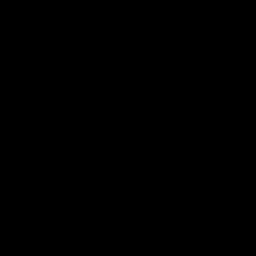

1652 JPEG RGB clrs 1 [(65536, (0, 0, 0))] black 65536|100.0% white 0|0.0% ; border-bw 100.0% 0.0% ; seed: None


In [55]:
imdb = M.num2tile('ch.mbtiles', z, x, y, flip_y=True)
info(imdb)

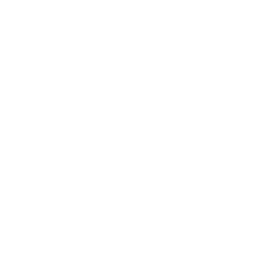

1651 JPEG RGB clrs 1 [(65536, (255, 255, 255))] black 0|0.0% white 65536|100.0% ; border-bw 0.0% 100.0% ; seed: (0, 0)


In [56]:
imdw = M.lnglat2tile('ch.mbtiles', 16, lng=10.19, lat=46.3)
info(imdw)

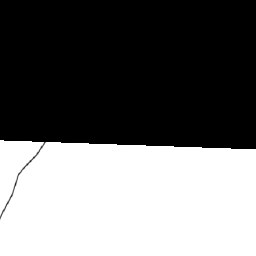

2976 JPEG RGB clrs 166 [(27495, (255, 255, 255))...(36786, (0, 0, 0))] black 36786|56.1% white 27495|42.0% ; border-bw 53.1% 45.3% ; seed: (160, 0)


In [57]:
imdbw = M.lnglat2tile('ch.mbtiles', 16, lng=10.19, lat=46.433)
info(imdbw)

⚠ Image out of bounds in zoom 16 (landeskarte-10 downscaled) can be all white / black or a mix.
At lower zoom, we can get a "gray cross on white":

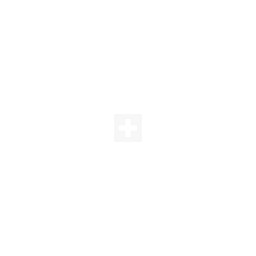

810 JPEG RGB clrs 13 [(64752, (255, 255, 255)), (38, (253, 253, 253)), (22, (251, 251, 251)), (88, (249, 249, 249)), (168, (247, 247, 247)), (52, (245, 245, 245)), (2, (243, 243, 243)), (86, (254, 254, 254)), (38, (252, 252, 252)), (4, (250, 250, 250)), (188, (248, 248, 248)), (92, (246, 246, 246)), (6, (244, 244, 244))] black 0|0.0% white 64752|98.8% ; border-bw 0.0% 100.0% ; seed: (0, 0)


In [58]:
imdwcr = M.lnglat2tile('ch.mbtiles', 13, lng=bbchse.e - EPSILON, lat=bbchse.s + EPSILON)
info(imdwcr)

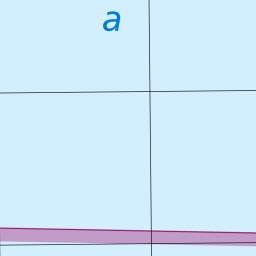

3547 JPEG RGB clrs 2622 [(1, (206, 255, 255))...(1, (21, 11, 38))] black 0|0.0% white 0|0.0% ; border-bw 0.0% 0.0% ; seed: None


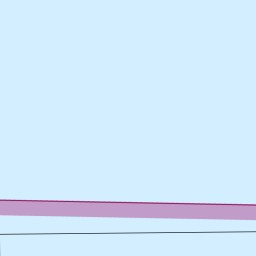

2535 JPEG RGB clrs 1451 [(35, (199, 153, 200))...(1, (192, 175, 209))] black 0|0.0% white 0|0.0% ; border-bw 0.0% 0.0% ; seed: None


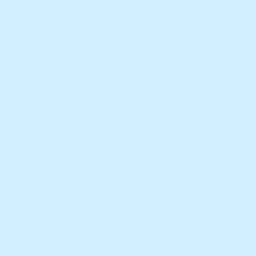

1653 JPEG RGB clrs 1 [(65536, (211, 238, 255))] black 0|0.0% white 0|0.0% ; border-bw 0.0% 0.0% ; seed: None


In [59]:
# assumptions about size, number of colors do not hold for lakes

for z in range(14,17):
    imd = M.lnglat2tile('ch.mbtiles', z, lng=6.66, lat=46.46)
    info(imd)

## Can we use a threshold eg 3% on global number of white pixels? → no

images below have up to 8.3 % of white pixels despite not being partial. 3-5% is quite common. So we need to use borders only.

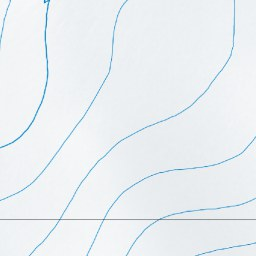

9439 JPEG RGB clrs 6747 [(1, (255, 255, 237))...(1, (255, 255, 255))] black 0|0.0% white 1|0.0% ; border-bw 0.0% 0.0% ; seed: None


In [60]:
# glaciers pose no issue as they are not white
imdglacier = M.lnglat2tile('ch.mbtiles', 16, lng=7.551, lat=46)
info(imdglacier)
# There are 6747 colors ... and only one "real white" pixel

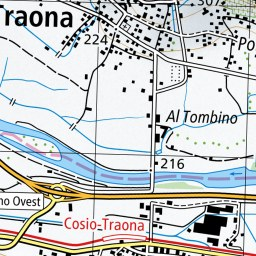

32656 JPEG RGB clrs 23073 [(364, (255, 255, 255))...(392, (0, 0, 2))] black 147|0.2% white 364|0.6% ; border-bw 0.0% 0.8% ; seed: None


In [61]:
# no issues with cities either
imd9 = M.lnglat2tile('ch.mbtiles', 14, lng=9.517, lat=46.14)
# imd9 = M.lnglat2tile('ch.mbtiles', 14, lng=9.67, lat=46.167)
info(imd9)

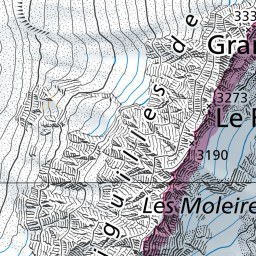

38187 JPEG RGB clrs 15274 [(3462, (255, 255, 255))...(96, (0, 0, 0))] black 96|0.1% white 3462|5.3% ; border-bw 0.1% 4.8% ; seed: None


In [62]:
imd5 = M.lnglat2tile('ch.mbtiles', 15, lng=7.28, lat=45.91)
info(imd5)

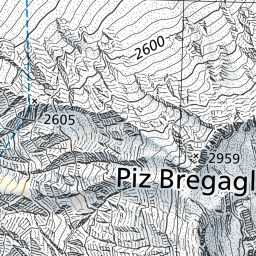

39660 JPEG RGB clrs 8009 [(5409, (255, 255, 255))...(29, (0, 0, 0))] black 29|0.0% white 5409|8.3% ; border-bw 0.0% 10.2% ; seed: None


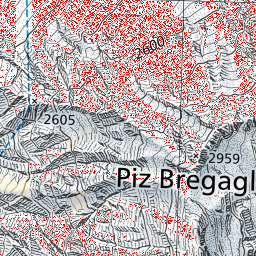

In [63]:
imd = M.num2tile('ch.mbtiles', 15, 17265, 21157)
info(imd)
rgb[G.np_equal(rgb, G.NP_WHITE)] = np.array((255, 0, 0))
Img.fromarray(rgb)

36266 JPEG RGB clrs 27035 [(749, (255, 255, 253))...(942, (255, 255, 255))] black 28|0.0% white 942|1.4% ; border-bw 0.0% 3.1% ; seed: None
((0, 128), None)


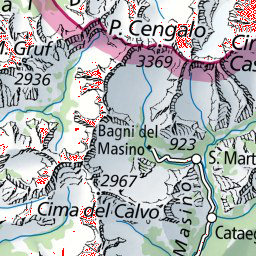

40785 JPEG RGB clrs 11280 [(1339, (255, 255, 255))...(12, (255, 255, 239))] black 79|0.1% white 1339|2.0% ; border-bw 0.0% 3.0% ; seed: None
((64, 255), None)


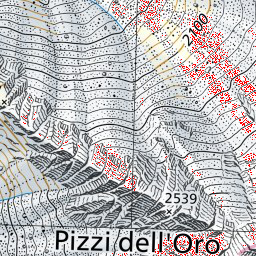

In [64]:
# however even limiting to border we can have 3% white, that is not contiguous :(
    # so that's why we choose to search for seed at specific positions
for z in 11, 15:
    imdbw = M.lnglat2tile('ch.mbtiles',z, lng=9.55, lat=46.26)
    info(imdbw, disp=False)
    print(G.get_color_seed(rgb, tryharder=1)) #, G.has_many_contiguous(rgb))
    rgb[G.np_equal(rgb, G.NP_WHITE)] = np.array((255, 0, 0))
    display(Img.fromarray(rgb))

39818 JPEG RGB clrs 28663 [(31, (255, 255, 227))...(12, (255, 255, 223))] black 46|0.1% white 1761|2.7% ; border-bw 0.0% 10.6% ; seed: (32, 255)
((128, 255), None)


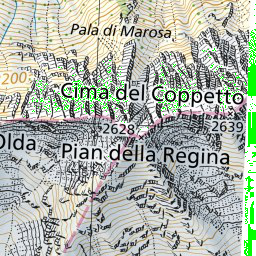

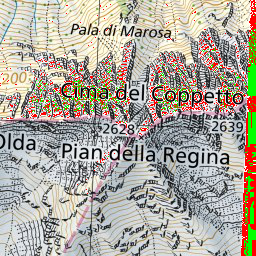

In [65]:
# because of jpeg compression, white is not that white :-|

imd = M.lnglat2tile('ch.mbtiles', 14, lng=10.4, lat=46.11)
info(imd, disp=False)
print(G.get_color_seed(rgb, tryharder=1)) #, G.has_many_contiguous(rgb))
rgb[G.np_equal(rgb, G.NP_WHITE)] = np.array((0, 255, 0))
display(Img.fromarray(rgb))
rgb[G.mask_color(rgb, color=G.NP_WHITE)] = np.array((255, 0, 0))
display(Img.fromarray(rgb))

818 JPEG RGB clrs 13 [(64461, (255, 255, 255)), (114, (253, 253, 253)), (23, (251, 251, 251)), (88, (249, 249, 249)), (168, (247, 247, 247)), (52, (245, 245, 245)), (2, (243, 243, 243)), (269, (254, 254, 254)), (69, (252, 252, 252)), (4, (250, 250, 250)), (188, (248, 248, 248)), (92, (246, 246, 246)), (6, (244, 244, 244))] black 0|0.0% white 64461|98.4% ; border-bw 0.0% 96.3% ; seed: (0, 0)
((0, 0), None)


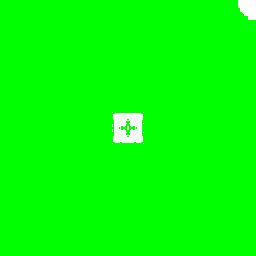

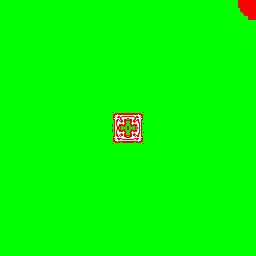

In [72]:

imd = M.lnglat2tile('ch.mbtiles', 15, lng=9.51, lat=46.33)
info(imd, disp=False)
print(G.get_color_seed(rgb, tryharder=1)) #, G.has_many_contiguous(rgb))
rgb[G.np_equal(rgb, G.NP_WHITE)] = np.array((0, 255, 0))
display(Img.fromarray(rgb))
rgb[G.mask_color(rgb, color=G.NP_WHITE)] = np.array((255, 0, 0))
display(Img.fromarray(rgb))

39818 JPEG RGB clrs 28663 [(31, (255, 255, 227))...(12, (255, 255, 223))] black 46|0.1% white 1761|2.7% ; border-bw 0.0% 10.6% ; seed: (32, 255)
((128, 255), None)


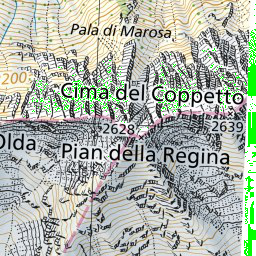

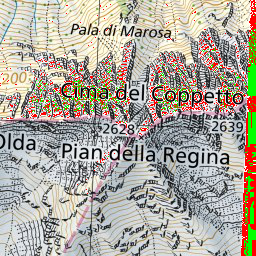

In [75]:

imd = M.lnglat2tile('ch.mbtiles', 14, lng=10.4, lat=46.11)
info(imd, disp=False)
print(G.get_color_seed(rgb, tryharder=1)) #, G.has_many_contiguous(rgb))
rgb[G.np_equal(rgb, G.NP_WHITE)] = np.array((0, 255, 0))
display(Img.fromarray(rgb))
rgb[G.mask_color(rgb, color=G.NP_WHITE)] = np.array((255, 0, 0))
display(Img.fromarray(rgb))

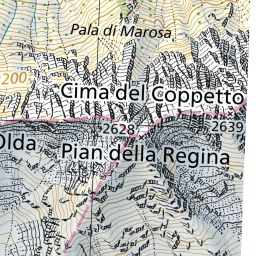

39818 JPEG RGB clrs 28663 [(31, (255, 255, 227))...(12, (255, 255, 223))] black 46|0.1% white 1761|2.7% ; border-bw 0.0% 10.6% ; seed: (32, 255)


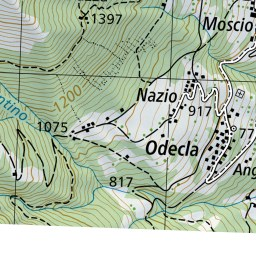

30678 JPEG RGB clrs 32010 [(4666, (255, 255, 255))...(4, (0, 0, 4))] black 14|0.0% white 4666|7.1% ; border-bw 0.0% 29.6% ; seed: (224, 0)


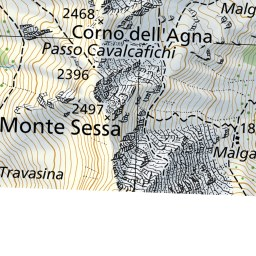

29351 JPEG RGB clrs 25193 [(23, (255, 255, 243))...(31, (255, 255, 239))] black 4|0.0% white 15288|23.3% ; border-bw 0.0% 36.2% ; seed: (192, 0)


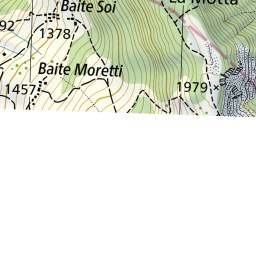

16767 JPEG RGB clrs 20246 [(34, (255, 255, 243))...(1, (0, 0, 8))] black 0|0.0% white 34978|53.4% ; border-bw 0.0% 51.8% ; seed: (128, 0)


In [66]:
# border white works very well for partial image (eg with threshold 5%), unlike overall white-ratio which can be low
for lng in 10.4, 10.3, 10.2, 10.0:
    imd = M.lnglat2tile('ch.mbtiles', 14, lng=lng, lat=46.11)
    info(imd)

## Can we use size to discriminate full and partial tile? -> no

In [ ]:
# partial tiles can have any size

import collections
ntsize = collections.defaultdict(int)
for (z, x, y, imd) in M.get_all_tiles('partial_1639023416chse.mbtiles'):
    ntsize[len(imd)//1000*1000] += 1
print(list(sorted((k, v) for k, v in ntsize.items())))
# d = dict()
# d.update(ntsize)
# d

[(4000, 3),
 (5000, 7),
 (6000, 14),
 (7000, 17),
 (8000, 25),
 (9000, 31),
 (10000, 30),
 (11000, 26),
 (12000, 18),
 (13000, 22),
 (14000, 17),
 (15000, 19),
 (16000, 25),
 (17000, 15),
 (18000, 26),
 (19000, 23),
 (20000, 30),
 (21000, 25),
 (22000, 30),
 (23000, 26),
 (24000, 26),
 (25000, 36),
 (26000, 23),
 (27000, 23),
 (28000, 19),
 (29000, 28),
 (30000, 24),
 (31000, 31),
 (32000, 36),
 (33000, 21),
 (34000, 15),
 (35000, 8),
 (36000, 5),
 (37000, 1),
 (39000, 1)]

In [ ]:
ntsize2 = collections.defaultdict(int)
for (z, x, y, imd) in M.get_all_tiles('clean_1639023416chse.mbtiles'):
    ntsize2[len(imd)//1000*1000] += 1
list(sorted((k, v) for k, v in ntsize2.items()))

[(4000, 6),
 (5000, 6),
 (6000, 3),
 (7000, 8),
 (8000, 6),
 (9000, 10),
 (10000, 8),
 (11000, 20),
 (12000, 26),
 (13000, 33),
 (14000, 47),
 (15000, 89),
 (16000, 135),
 (17000, 209),
 (18000, 371),
 (19000, 506),
 (20000, 741),
 (21000, 964),
 (22000, 1089),
 (23000, 1207),
 (24000, 1307),
 (25000, 1337),
 (26000, 1245),
 (27000, 1281),
 (28000, 1275),
 (29000, 1322),
 (30000, 1516),
 (31000, 1724),
 (32000, 1840),
 (33000, 1569),
 (34000, 1261),
 (35000, 960),
 (36000, 825),
 (37000, 855),
 (38000, 735),
 (39000, 625),
 (40000, 346),
 (41000, 161),
 (42000, 57),
 (43000, 13),
 (44000, 1)]

In [70]:
G.border_percent(rgb, G.NP_WHITE)

0.0

## Find out if it works

(this part needs cleanup.
actual implem ended up in `mbt_download.py`)

In [27]:
import sqlite3
import collections

PIXELS = 256**2

def clean_reasons(mbt):
    '''Clean file in place.'''
    reasons = collections.defaultdict(int)
    samples = collections.defaultdict(list)
    for z, x, y, imd in M.get_all_tiles(mbt):
        im = Img.open(io.BytesIO(imd))
        colors = im.getcolors(256**2)
        reason = ''
        if len(imd) < 4000:
            reason += 'small '
        if len(colors) < 300:
            reason += 'fewcolors '
        nbw = 0
        for n, c in colors:
            if c in ((255,255,255),(0,0,0)):
                nbw += n

        if nbw > 0.8 * PIXELS:
            reason += 'tooblorwh'
        elif nbw > 0.05 * PIXELS:
            reason += 'partial'
        if reason:
            reasons[reason] += 1
            if reasons[reason] < 20:
                samples[reason].append((z, x, y))
    return reasons , samples

# reasons, samples = clean_reasons('chse.mbtiles')  # 8m
reasons, samples = clean_reasons('tocltest.mbtiles')
reasons

defaultdict(int,
            {'partial': 162,
             'small fewcolors tooblorwh': 712,
             'small tooblorwh': 14,
             'tooblorwh': 13})

In [19]:
r = MP.clean_missing_data('tocltest.mbtiles')
r

Deleted 0. Status: 0 / 5000
Deleted 0. Status: 200 / 27
Deleted 16. Status: 400 / 56
Deleted 17. Status: 600 / 38
Deleted 61. Status: 800 / 2
Deleted 15. Status: 1000 / 2
Deleted 17. Status: 1200 / 14
Deleted 14. Status: 1400 / 11
Deleted 15. Status: 1600 / 3
Deleted 12. Status: 1800 / 10
Deleted 12. Status: 2000 / 38
Deleted 12. Status: 2200 / 8
Deleted 14. Status: 2400 / 58
Deleted 14. Status: 2600 / 16
Deleted 8. Status: 2800 / 1
Deleted 127. Status: 3000 / 40
Deleted 93. Status: 3200 / 3191
Deleted 66. Status: 3400 / 2253
Deleted 46. Status: 3600 / 28
Deleted 47. Status: 3800 / 3
Deleted 46. Status: 4000 / 392
Deleted 43. Status: 4200 / 1
Deleted 48. Status: 4400 / 13
Deleted 53. Status: 4600 / 18078
Deleted 57. Status: 4800 / 1
Deleted 48. Status: 4999 / 1


(defaultdict(int,
             {'9 ': 4,
              '10 ': 9,
              '11 ': 36,
              '12 ': 144,
              '13 ': 482,
              '13 partial': 38,
              '13 fewcolors ': 50,
              '13 tooblackorwhite': 6,
              '14 ': 1988,
              '14 partial': 62,
              '14 fewcolors ': 239,
              '14 tooblackorwhite': 15,
              '15 ': 1436,
              '15 partial': 62,
              '15 tooblackorwhite': 6,
              '15 fewcolors ': 423}),
 defaultdict(list, {}))